# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
url = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
base_url = 'http://www.indeed.com/jobs?q=data+scientist&jt=fulltime&sort='
sort_by = 'date'          # sort by data
start_from = '&start='    # start page number

In [3]:
url = "%s%s%s%d" % (base_url, sort_by, start_from, 10) 

In [4]:
url_template.format('New+York', 10)

'http://www.indeed.com/jobs?q=data+scientist&jt=fulltime&sort=date&start=10'

In [61]:
% matplotlib inline

In [79]:
import numpy as np

In [67]:
import urllib2, requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

In [68]:
df = pd.DataFrame()   # create a new data frame
pd.set_option('max_colwidth',500)    # to remove column limit (default is 50. Otherwise, we'll lose some info)

In [70]:
YOUR_CITY = 'Hong+Kong'
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 5000 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

#results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
    
    
    for start in range(0, max_results_per_city, 10):
        
        
        url = url_template.format(city, start)
        contents = BeautifulSoup(urllib2.urlopen(url), "lxml") 
        contentsElements = contents.find_all('div', attrs={'class' : '  row  result'}) 
        
        for elem in contentsElements: 
            try:
                company = elem.find('span', attrs={'itemprop':'name'}).getText().strip() #strips off whitespace 
            except AttributeError:
                company = '-'


            try:
                salary = elem.find('nobr').getText().strip()
            except AttributeError:   
                salary = '-'


            job_title = elem.find('a', attrs={'class':'turnstileLink'}).attrs['title']


            home_url = "http://www.indeed.com"
            job_link = "%s%s" % (home_url,elem.find('a').get('href'))

            job_addr = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()

            job_posted = elem.find('span', attrs={'class': 'date'}).getText()


            # add a record of job info to our data frame
            df = df.append({'company': company, 
                            'salary': salary,
                            'job_title': job_title, 
                            'job_link': job_link, 
                            'job_posted': job_posted,
                            'job_location': job_addr
                           }, ignore_index=True)

        
        # Grab the results from the request (as above)
        # Append to the full set of results
        # pass

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5672 entries, 0 to 44504
Data columns (total 7 columns):
company         5672 non-null object
job_link        5672 non-null object
job_location    5672 non-null object
job_posted      5672 non-null object
job_title       5672 non-null object
salary          5672 non-null object
location        5672 non-null object
dtypes: object(7)
memory usage: 354.5+ KB


In [85]:
df_original = df.copy()

In [227]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48425 entries, 0 to 48424
Data columns (total 6 columns):
company         48425 non-null object
job_link        48425 non-null object
job_location    48425 non-null object
job_posted      48425 non-null object
job_title       48425 non-null object
salary          48425 non-null object
dtypes: object(6)
memory usage: 2.2+ MB


In [228]:
df = df_original.copy()

In [229]:
len(df['job_link'].unique())

5672

In [230]:
df= df.drop_duplicates('job_link')

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5672 entries, 0 to 44504
Data columns (total 6 columns):
company         5672 non-null object
job_link        5672 non-null object
job_location    5672 non-null object
job_posted      5672 non-null object
job_title       5672 non-null object
salary          5672 non-null object
dtypes: object(6)
memory usage: 310.2+ KB


In [232]:
df[df['salary']!='-']

,company,job_link,job_location,job_posted,job_title,salary
1,Oscar Technology,http://www.indeed.com/cmp/Oscar-Technology/jobs/Big-Data-Analytic-Manager-e2a5c1c0e18a816f?r=1&fccid=91b9efb3f8516152,"Houston, TX",30 days ago,Big Data Analytics Manager,"$160,000 a year"
5,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=a7c0bfe4dc18c598&fccid=5f589639ccd58869,"Houston, TX",5 days ago,Bioinformatics Programmer II,"$70,000 a year"
8,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=9832cb2739cb7bf7&fccid=5f589639ccd58869,"Houston, TX",11 days ago,Research Assistant I,"$36,000 a year"
31,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=9f68eb0722f870cb&fccid=5f589639ccd58869,"Houston, TX",27 days ago,Java Programmer,"$93,431 a year"
32,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=5be5e4195e9118fe&fccid=5f589639ccd58869,"Houston, TX",18 days ago,Quality Assurance and Research Analyst,"$49,506 a year"
38,MD ANDERSON CANCER CENTER,http://www.indeed.com/rc/clk?jk=c8f0a46736a4bd14&fccid=ab68ed48b7ae3b5f,"Houston, TX",14 days ago,Market Research Analyst - Innovation,"$80,000 - $100,000 a year"
57,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=5bf5fa0d0792e13c&fccid=5f589639ccd58869,"Houston, TX",30+ days ago,Senior Research Quality Assurance Analyst,"$54,590 a year"
66,Texas A&M University,http://www.indeed.com/cmp/Texas-A&M-University/jobs/Bioinformatic-Postdoctoral-Fellow-4a438838eee5f62a?r=1&fccid=dd6ff7cf2fa06fa5,"Houston, TX 77058 (Pasadena area)",27 days ago,Bioinformatics Postdoctoral Fellow,"$70,000 a year"
90,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=684e8d5fd171755b&fccid=5f589639ccd58869,"Houston, TX",30+ days ago,Cytometry Technician,"$28,909 - $36,000 a year"
124,Burnett Staffing,http://www.indeed.com/rc/clk?jk=de45d706461899fb&fccid=8404a858554c32cb,"Houston, TX",30+ days ago,Research Billing Compliance Analyst,$25 - $45 an hour


In [233]:
df['salary'].value_counts()

-                             5220
$150,000 a year                 12
$68,239 - $85,644 a year        12
$6,250 - $10,833 a month        10
$125,000 - $150,000 a year       8
$5,400 - $6,500 a month          8
$180,000 a year                  5
$125,000 a year                  5
$80,000 - $100,000 a year        5
$100,000 a year                  5
$4,693 - $7,395 a month          4
$200,000 a year                  4
$100,000 - $150,000 a year       4
$120,000 a year                  4
$80,000 - $200,000 a year        4
$160,000 a year                  4
$130,000 a year                  4
$100,000 - $200,000 a year       4
$3,223 - $4,324 a month          4
$90,000 a year                   4
$170,000 a year                  4
$2,882 - $3,840 a month          4
$110,000 a year                  4
$105,000 a year                  4
$100,000 - $120,000 a year       3
$7,083 - $9,166 a month          3
$70,000 a year                   3
$140,000 - $160,000 a year       3
$80,000 - $120,000 a

In [234]:
df.head()

,company,job_link,job_location,job_posted,job_title,salary
0,Exxon Mobil,http://www.indeed.com/rc/clk?jk=d0ff641055a3b2e2&fccid=1ddb91d85c72e885,"Houston, TX",11 days ago,2017 Computational Sciences,-
1,Oscar Technology,http://www.indeed.com/cmp/Oscar-Technology/jobs/Big-Data-Analytic-Manager-e2a5c1c0e18a816f?r=1&fccid=91b9efb3f8516152,"Houston, TX",30 days ago,Big Data Analytics Manager,"$160,000 a year"
2,UT Health Science Center at Houston,http://www.indeed.com/rc/clk?jk=434e832157e2db75&fccid=2259246cd8a35c6c,"Houston, TX",16 days ago,Research Scientist Sr. - Bioinformatics,-
3,"GeoControl Systems, Inc.","http://www.indeed.com/cmp/GeoControl-Systems,-Inc./jobs/Research-Scientist-5db12808e2bcf134?r=1&fccid=3eebce6848263e88","Houston, TX",26 days ago,Research Scientist,-
4,YES Prep Public Schools,http://www.indeed.com/rc/clk?jk=872b37ebe99d56f2&fccid=4bdd1ddb2aab636b,"Houston, TX 77050",5 days ago,Research and Data Analyst,-


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5672 entries, 0 to 44504
Data columns (total 6 columns):
company         5672 non-null object
job_link        5672 non-null object
job_location    5672 non-null object
job_posted      5672 non-null object
job_title       5672 non-null object
salary          5672 non-null object
dtypes: object(6)
memory usage: 310.2+ KB


In [236]:
cities = ['New York', 'Chicago', 'San Francisco', 'Austin', 'Seattle', 
    'Los Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Hong Kong']

for city in cities:
    df.ix[df['job_location'].str.contains(city),'location'] = city


In [237]:
df[df['location']=="New York"]

,company,job_link,job_location,job_posted,job_title,salary,location
22426,SoundCloud,http://www.indeed.com/rc/clk?jk=c1f44bb3c93cdb5d&fccid=af61bf95b89c7cb2,"New York, NY 10003 (Greenwich Village area)",4 hours ago,"Data Scientist, Analytics",-,New York
22427,American Express,http://www.indeed.com/rc/clk?jk=4533b035cbc93104&fccid=f057e04c37cca134,"New York, NY",6 days ago,"Director, US Customer Marketing Data Science",-,New York
22428,JW Player,http://www.indeed.com/rc/clk?jk=bbd156334642a854&fccid=302ac6eda058f71c,"New York, NY 10018 (Clinton area)",3 days ago,Data Scientist,-,New York
22429,VROOM,http://www.indeed.com/rc/clk?jk=7826f95a63ea19d8&fccid=2ab13947fbb2d925,"New York, NY",13 days ago,Data Scientist,"$100,000 - $120,000 a year",New York
22430,UncommonGoods,http://www.indeed.com/rc/clk?jk=b5068983bb26cff7&fccid=5b0f69175b6d1208,"New York, NY 10014 (West Village area)",5 days ago,Junior Data Scientist,-,New York
22431,Wade & Wendy,http://www.indeed.com/rc/clk?jk=26351741201154c5&fccid=163fc1e8f2ac4e32,"New York, NY",10 days ago,Wade & Wendy_Data Scientist/Engineer,"$80,000 - $120,000 a year",New York
22432,Carrot Creative,http://www.indeed.com/rc/clk?jk=3bd10da80c02ccfb&fccid=f4316a3c4f4e2e4c,"New York, NY",6 days ago,Data Scientist,-,New York
22433,Beeswax,http://www.indeed.com/rc/clk?jk=ceae614e67e01d84&fccid=1b5614d5a9ded7e8,"New York, NY",5 days ago,"Software Engineer, Machine Learning and Optimization",-,New York
22434,OnDeck,http://www.indeed.com/rc/clk?jk=95ab885e2c613f29&fccid=48638adc95945cc6,"New York, NY",4 days ago,Data Engineer,-,New York
22435,CAPCO,http://www.indeed.com/rc/clk?jk=74384814fb3f8ad4&fccid=c2a63affe8751868,"New York, NY 10271 (Financial District area)",1 day ago,Senior Data Scientist,-,New York


In [238]:
df[df['location'].isnull()]['job_location'].value_counts()

Boulder, CO                                     89
Berkeley, CA                                    62
Redmond, WA                                     60
Redwood City, CA                                59
Redmond, WA 98052                               49
Bellevue, WA                                    46
Foster City, CA                                 45
Plano, TX                                       44
Westminster, CO                                 34
King of Prussia, PA                             32
Pasadena, CA                                    29
San Mateo, CA                                   29
Oakland, CA                                     28
Dania Beach, FL                                 27
Santa Monica, CA                                27
Emeryville, CA 94608                            27
Collegeville, PA 19426                          26
Fort Lauderdale, FL                             25
West Point, PA                                  24
Broomfield, CO                 

In [239]:
df[df['location'].isnull()] = 'Other'

In [240]:
df[df['location'].isnull()==False]['location'].value_counts()

Other            2076
San Francisco     701
New York          644
Seattle           582
Chicago           362
Philadelphia      237
Atlanta           199
Los Angeles       184
Austin            163
Houston           158
Dallas             92
Denver             72
Portland           64
Pittsburgh         59
Phoenix            47
Miami              32
Name: location, dtype: int64

In [241]:
df_sal = df[df['salary']!='-']

In [242]:
df_sal.head()

,company,job_link,job_location,job_posted,job_title,salary,location
1,Oscar Technology,http://www.indeed.com/cmp/Oscar-Technology/jobs/Big-Data-Analytic-Manager-e2a5c1c0e18a816f?r=1&fccid=91b9efb3f8516152,"Houston, TX",30 days ago,Big Data Analytics Manager,"$160,000 a year",Houston
5,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=a7c0bfe4dc18c598&fccid=5f589639ccd58869,"Houston, TX",5 days ago,Bioinformatics Programmer II,"$70,000 a year",Houston
8,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=9832cb2739cb7bf7&fccid=5f589639ccd58869,"Houston, TX",11 days ago,Research Assistant I,"$36,000 a year",Houston
22,Other,Other,Other,Other,Other,Other,Other
31,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=9f68eb0722f870cb&fccid=5f589639ccd58869,"Houston, TX",27 days ago,Java Programmer,"$93,431 a year",Houston


In [251]:
df_sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2405 entries, 1 to 44503
Data columns (total 8 columns):
company         2405 non-null object
job_link        2405 non-null object
job_location    2405 non-null object
job_posted      2405 non-null object
job_title       2405 non-null object
salary          2405 non-null object
location        2405 non-null object
salary_calc     329 non-null float64
dtypes: float64(1), object(7)
memory usage: 169.1+ KB


In [243]:
min_max_sal = df_sal['salary'].str.split('-', expand=True)

In [244]:
min_max_sal.columns = ['min_sal', 'max_sal']

In [245]:
min_max_sal['is_year'] = (min_max_sal['min_sal'].str.find('year') > 0) | (min_max_sal['max_sal'].str.find('year') > 0)
min_max_sal['is_month'] = (min_max_sal['min_sal'].str.find('month') > 0) | (min_max_sal['max_sal'].str.find('month') > 0)
min_max_sal['is_week'] = (min_max_sal['min_sal'].str.find('week') > 0) | (min_max_sal['max_sal'].str.find('week') > 0)
min_max_sal['is_day'] = (min_max_sal['min_sal'].str.find('day') > 0) | (min_max_sal['max_sal'].str.find('day') > 0)
min_max_sal['is_hour'] = (min_max_sal['min_sal'].str.find('hour') > 0) | (min_max_sal['max_sal'].str.find('hour') > 0)

In [246]:
cols = ['min_sal','max_sal']
for col in cols:
    min_max_sal[col] = min_max_sal[col].str.replace('$','').str.replace(',','')
    min_max_sal[col] = min_max_sal[col].str.replace(' a year','').str.replace(' a month','')
    min_max_sal[col] = min_max_sal[col].str.replace(' a week','')
    min_max_sal[col] = min_max_sal[col].str.replace(' a day','').str.replace(' an hour','')



In [247]:
min_max_sal['min_sal'] = pd.to_numeric(min_max_sal['min_sal'], errors='coerce')
min_max_sal['max_sal'] = pd.to_numeric(min_max_sal['max_sal'], errors='coerce')

In [248]:


min_max_sal.ix[min_max_sal['max_sal'].isnull()==False,'sal_calc'] = (min_max_sal[min_max_sal['max_sal'].isnull()==False]['min_sal']+min_max_sal[min_max_sal['max_sal'].isnull()==False]['max_sal'])/2.0
min_max_sal.ix[min_max_sal['sal_calc'].isnull(),'sal_calc'] = min_max_sal.ix[min_max_sal['sal_calc'].isnull(),'min_sal']

min_max_sal.ix[min_max_sal['is_month'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_month'],'sal_calc'] * 12
#assumes 52 weeks per year  
min_max_sal.ix[min_max_sal['is_week'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_week'],'sal_calc'] * 52
#assumes 40 hr work week
min_max_sal.ix[min_max_sal['is_day'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_day'],'sal_calc'] * 5 * 52
#assumes 8 hr work day
min_max_sal.ix[min_max_sal['is_hour'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_hour'],'sal_calc'] * 8 * 5 * 52



In [249]:
df_sal['salary_calc'] = min_max_sal['sal_calc']

/home/vagrant/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [250]:
df_sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2405 entries, 1 to 44503
Data columns (total 8 columns):
company         2405 non-null object
job_link        2405 non-null object
job_location    2405 non-null object
job_posted      2405 non-null object
job_title       2405 non-null object
salary          2405 non-null object
location        2405 non-null object
salary_calc     329 non-null float64
dtypes: float64(1), object(7)
memory usage: 169.1+ KB


In [216]:
df_sal[df_sal['job_location']>200000]

,company,job_link,job_location,job_posted,job_title,salary,location,salary_calc
1,Oscar Technology,http://www.indeed.com/cmp/Oscar-Technology/jobs/Big-Data-Analytic-Manager-e2a5c1c0e18a816f?r=1&fccid=91b9efb3f8516152,"Houston, TX",30 days ago,Big Data Analytics Manager,"$160,000 a year",Houston,160000.0
5,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=a7c0bfe4dc18c598&fccid=5f589639ccd58869,"Houston, TX",5 days ago,Bioinformatics Programmer II,"$70,000 a year",Houston,70000.0
8,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=9832cb2739cb7bf7&fccid=5f589639ccd58869,"Houston, TX",11 days ago,Research Assistant I,"$36,000 a year",Houston,36000.0
22,Other,Other,Other,Other,Other,Other,Other,NaN
31,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=9f68eb0722f870cb&fccid=5f589639ccd58869,"Houston, TX",27 days ago,Java Programmer,"$93,431 a year",Houston,93431.0
32,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=5be5e4195e9118fe&fccid=5f589639ccd58869,"Houston, TX",18 days ago,Quality Assurance and Research Analyst,"$49,506 a year",Houston,49506.0
38,MD ANDERSON CANCER CENTER,http://www.indeed.com/rc/clk?jk=c8f0a46736a4bd14&fccid=ab68ed48b7ae3b5f,"Houston, TX",14 days ago,Market Research Analyst - Innovation,"$80,000 - $100,000 a year",Houston,90000.0
51,Other,Other,Other,Other,Other,Other,Other,NaN
57,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=5bf5fa0d0792e13c&fccid=5f589639ccd58869,"Houston, TX",30+ days ago,Senior Research Quality Assurance Analyst,"$54,590 a year",Houston,54590.0
66,Texas A&M University,http://www.indeed.com/cmp/Texas-A&M-University/jobs/Bioinformatic-Postdoctoral-Fellow-4a438838eee5f62a?r=1&fccid=dd6ff7cf2fa06fa5,"Houston, TX 77058 (Pasadena area)",27 days ago,Bioinformatics Postdoctoral Fellow,"$70,000 a year",Houston,70000.0


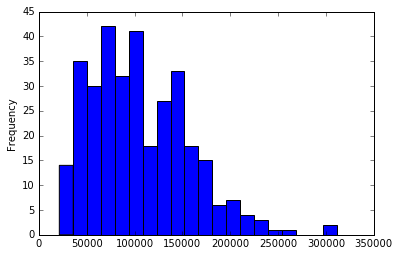

In [217]:
df_sal['salary_calc'].plot(kind='hist', bins=20)

In [218]:
df_sal[df_sal['salary_calc']>200000]

,company,job_link,job_location,job_posted,job_title,salary,location,salary_calc
7730,Jobspring Partners,http://www.indeed.com/rc/clk?jk=510c52c30e97883c&fccid=4a2d2fbadf14d480,"San Francisco, CA",30+ days ago,Vice President Engineering (Big Data/ Machine Learning),"$180,000 - $275,000 a year",San Francisco,227500.0
22442,Brilliant Leap,http://www.indeed.com/cmp/Brilliant-Leap/jobs/Data-Scientist-1d9f07ff8aef0af1?r=1&fccid=82944c7d656c43dd,"New York, NY",18 days ago,Data Scientist,$800 a day,New York,208000.0
22509,Harnham,http://www.indeed.com/rc/clk?jk=ed804e9cea125191&fccid=d72eb0548d91249c,"New York, NY",12 days ago,Chief Data Scientist - Consulting,"$220,000 a year",New York,220000.0
22587,Harnham,http://www.indeed.com/rc/clk?jk=9b3f954c188612f7&fccid=d72eb0548d91249c,"New York, NY",12 days ago,Lead Data Scientist,"$250,000 a year",New York,250000.0
22725,Selby Jennings,http://www.indeed.com/rc/clk?jk=97cd5d8ef813e45a&fccid=e46dcf251ad893cd,"New York, NY 10167 (Midtown area)",30+ days ago,Contract:Data Scientist/Data Mining Specialist,$100 - $150 an hour,New York,260000.0
22759,Selby Jennings,http://www.indeed.com/rc/clk?jk=09888e9181953b0f&fccid=e46dcf251ad893cd,"New York, NY 10167 (Midtown area)",30+ days ago,Senior Quantitative/Machine Learning - Contract,$650 - $900 a day,New York,201500.0
22761,Harnham,http://www.indeed.com/rc/clk?jk=bcb9a6bc02244301&fccid=d72eb0548d91249c,"New York, NY",12 days ago,Big Data Architect,"$1,200 a day",New York,312000.0
22784,Harnham,http://www.indeed.com/rc/clk?jk=184088b0ff4a5009&fccid=d72eb0548d91249c,"New York, NY",12 days ago,"Big Data Architect - New York - Hadoop, NoSQL, MongoDB","$1,200 a day",New York,312000.0
22792,Averity,http://www.indeed.com/rc/clk?jk=56fd117bff74f3e9&fccid=39407476605079e0,"New York, NY",6 days ago,Quantitative Analyst for Global Quant Fund,"$150,000 - $300,000 a year",New York,225000.0
23142,Averity,http://www.indeed.com/rc/clk?jk=d5767a007507212b&fccid=39407476605079e0,"New York, NY",30+ days ago,Quantitative Data Scientist - Large Asset Manager,"$175,000 - $275,000 a year",New York,225000.0


In [220]:
[(c, df[c].value_counts().count()) for c in list(df.columns)]

[('company', 1461),
 ('job_link', 3597),
 ('job_location', 231),
 ('job_posted', 48),
 ('job_title', 2789),
 ('salary', 208),
 ('location', 16)]

In [221]:
df

,company,job_link,job_location,job_posted,job_title,salary,location
0,Exxon Mobil,http://www.indeed.com/rc/clk?jk=d0ff641055a3b2e2&fccid=1ddb91d85c72e885,"Houston, TX",11 days ago,2017 Computational Sciences,-,Houston
1,Oscar Technology,http://www.indeed.com/cmp/Oscar-Technology/jobs/Big-Data-Analytic-Manager-e2a5c1c0e18a816f?r=1&fccid=91b9efb3f8516152,"Houston, TX",30 days ago,Big Data Analytics Manager,"$160,000 a year",Houston
2,UT Health Science Center at Houston,http://www.indeed.com/rc/clk?jk=434e832157e2db75&fccid=2259246cd8a35c6c,"Houston, TX",16 days ago,Research Scientist Sr. - Bioinformatics,-,Houston
3,"GeoControl Systems, Inc.","http://www.indeed.com/cmp/GeoControl-Systems,-Inc./jobs/Research-Scientist-5db12808e2bcf134?r=1&fccid=3eebce6848263e88","Houston, TX",26 days ago,Research Scientist,-,Houston
4,YES Prep Public Schools,http://www.indeed.com/rc/clk?jk=872b37ebe99d56f2&fccid=4bdd1ddb2aab636b,"Houston, TX 77050",5 days ago,Research and Data Analyst,-,Houston
5,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=a7c0bfe4dc18c598&fccid=5f589639ccd58869,"Houston, TX",5 days ago,Bioinformatics Programmer II,"$70,000 a year",Houston
6,Panton,http://www.indeed.com/cmp/Panton-Incorporated/jobs/Junior-Data-Scientist-75965b54cfc10fc4?r=1&fccid=82695ab6fc073f1c,"Houston, TX",26 days ago,Junior Data Scientist,-,Houston
7,MD ANDERSON CANCER CENTER,http://www.indeed.com/rc/clk?jk=b9540cb6e891a52a&fccid=ab68ed48b7ae3b5f,"Houston, TX",19 days ago,Computational Scientist - Department of Immunology,-,Houston
8,Baylor College of Medicine,http://www.indeed.com/rc/clk?jk=9832cb2739cb7bf7&fccid=5f589639ccd58869,"Houston, TX",11 days ago,Research Assistant I,"$36,000 a year",Houston
9,MD ANDERSON CANCER CENTER,http://www.indeed.com/rc/clk?jk=73e961904ba25b14&fccid=ab68ed48b7ae3b5f,"Houston, TX",30+ days ago,Research Statistical Analyst,-,Houston


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [4]:
## YOUR CODE HERE

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [63]:
YOUR_CITY = 'Hong+Kong'

In [64]:
YOUR_CITY = 'Hong+Kong'
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 100 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        # Append to the full set of results
        pass

In [66]:
url_template.format('New+York', 10)

'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10'

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [7]:
## YOUR CODE HERE

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [9]:
## YOUR CODE HERE

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [10]:
## YOUR CODE HERE

### Save your results as a CSV

In [14]:
## YOUR CODE HERE

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [222]:
## YOUR CODE HERE
df_sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2405 entries, 1 to 44503
Data columns (total 8 columns):
company         2405 non-null object
job_link        2405 non-null object
job_location    2405 non-null object
job_posted      2405 non-null object
job_title       2405 non-null object
salary          2405 non-null object
location        2405 non-null object
salary_calc     329 non-null float64
dtypes: float64(1), object(7)
memory usage: 169.1+ KB


In [252]:
X = df_sal[df_sal['salary_calc'].isnull()==False]

In [254]:
X['salary_calc'].median()

99996.0

In [253]:
y = (X['salary_calc'] >= X['salary_calc'].median())

In [257]:
X = X.reindex(columns=['company','location','job_title'])

In [267]:
from sklearn import linear_model, metrics, cross_validation

In [262]:
X = pd.get_dummies(X)

In [268]:
logit = linear_model.LogisticRegression()

In [269]:
cross_validation.cross_val_score(linear_model.LogisticRegression(), X=X, y=y, cv=5)

array([ 0.71212121,  0.51515152,  0.54545455,  0.21212121,  0.55384615])

In [265]:
results

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [15]:
## YOUR CODE HERE

#### Thought experiment: What is the baseline accuracy for this model?

In [16]:
## YOUR CODE HERE

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [17]:
## YOUR CODE HERE

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [18]:
## YOUR CODE HERE

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [19]:
## YOUR CODE HERE

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [20]:
## YOUR CODE HERE

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [21]:
## YOUR CODE HERE

In [22]:
## YOUR CODE HERE

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [23]:
## YOUR CODE HERE

In [24]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [25]:
## YOUR CODE HERE